In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,Input, Dense, Lambda, Layer, Add, Multiply

from tensorflow.keras import backend as K
#
#from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.datasets import mnist


original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 20
epsilon_std = 1.0


In [2]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)


class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [3]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.


In [10]:
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=80,
        batch_size=batch_size,
        validation_data=(x_test, y_test))

encoder = Model(x, z_mu)


Train on 60000 samples, validate on 10000 samples
Epoch 1/80
60000/60000 [==============================] - 6s 97us/sample - loss: 157.5620 - val_loss: 54960.2550
Epoch 2/80
60000/60000 [==============================] - 6s 103us/sample - loss: 157.0000 - val_loss: 57418.8905
Epoch 3/80
60000/60000 [==============================] - 6s 97us/sample - loss: 156.5209 - val_loss: 58551.9720
Epoch 4/80
60000/60000 [==============================] - 6s 94us/sample - loss: 156.1038 - val_loss: 58875.0076
Epoch 5/80
60000/60000 [==============================] - 6s 94us/sample - loss: 155.6619 - val_loss: 61143.5522
Epoch 6/80
60000/60000 [==============================] - 6s 104us/sample - loss: 155.3032 - val_loss: 61681.6289
Epoch 7/80
60000/60000 [==============================] - 6s 93us/sample - loss: 154.9790 - val_loss: 62477.6902
Epoch 8/80
60000/60000 [==============================] - 6s 93us/sample - loss: 154.6521 - val_loss: 62273.2093
Epoch 9/80
60000/60000 [====================

60000/60000 [==============================] - 20s 332us/sample - loss: 147.9162 - val_loss: 87997.7641
Epoch 72/80
60000/60000 [==============================] - 20s 333us/sample - loss: 147.9535 - val_loss: 86815.5622
Epoch 73/80
60000/60000 [==============================] - 20s 340us/sample - loss: 147.8734 - val_loss: 86461.1362
Epoch 74/80
60000/60000 [==============================] - 20s 334us/sample - loss: 147.8065 - val_loss: 86553.7641
Epoch 75/80
60000/60000 [==============================] - 20s 335us/sample - loss: 147.7817 - val_loss: 86501.5216
Epoch 76/80
60000/60000 [==============================] - 20s 335us/sample - loss: 147.7402 - val_loss: 89419.6552
Epoch 77/80
60000/60000 [==============================] - 20s 341us/sample - loss: 147.7292 - val_loss: 86714.9495
Epoch 78/80
60000/60000 [==============================] - 22s 374us/sample - loss: 147.6536 - val_loss: 88444.5519
Epoch 79/80
60000/60000 [==============================] - 22s 373us/sample - loss: 

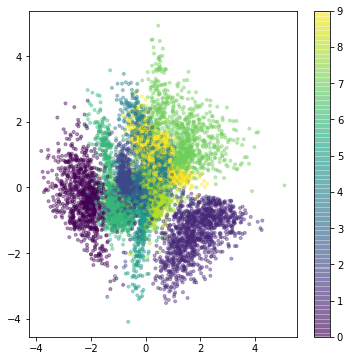

In [11]:
# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()


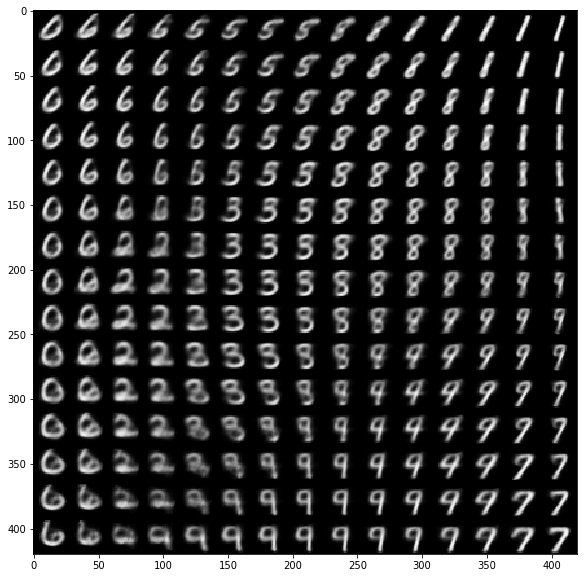

In [12]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
x_decoded = decoder.predict(z_grid.reshape(n*n, 2))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')


In [13]:
val=[-.2,.5]

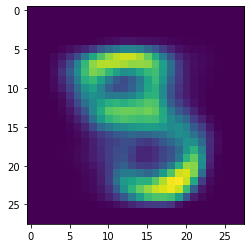

In [14]:
plt.imshow(decoder.predict(np.array(val).reshape(1,2)).reshape(digit_size, digit_size))